## Sagnac Frequency - Backscatter Correction - RZ shortterm

Explore the longterm behaviour of the RV sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [38]:
config = {}

config['ring'] = "Z"

config['delta'] = 60

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

# switch of PDs for monobeams at RZ & new control loop
config['tbeg'] = UTCDateTime("2024-08-09 11:00")
config['tend'] = UTCDateTime("2024-08-20 00:00")
flim1, flim2 = 553.569, 553.577

# path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }


## Configurations

In [7]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Compute Backscatter (again)

In [8]:
from functions.backscatter_correction import __backscatter_correction

In [9]:
bs['fj_bs'], _, _ = __backscatter_correction(bs.f1_ac / bs.f1_dc,
                                             bs.f2_ac / bs.f2_dc,
                                             np.unwrap(bs.f1_phw) - np.unwrap(bs.f2_phw),
                                             bs.fj_fs,
                                             np.nanmedian(bs.fj_fs),
                                             cm_filter_factor=1.033,
                                             )

<Figure size 1500x500 with 0 Axes>

(553.569, 553.577)

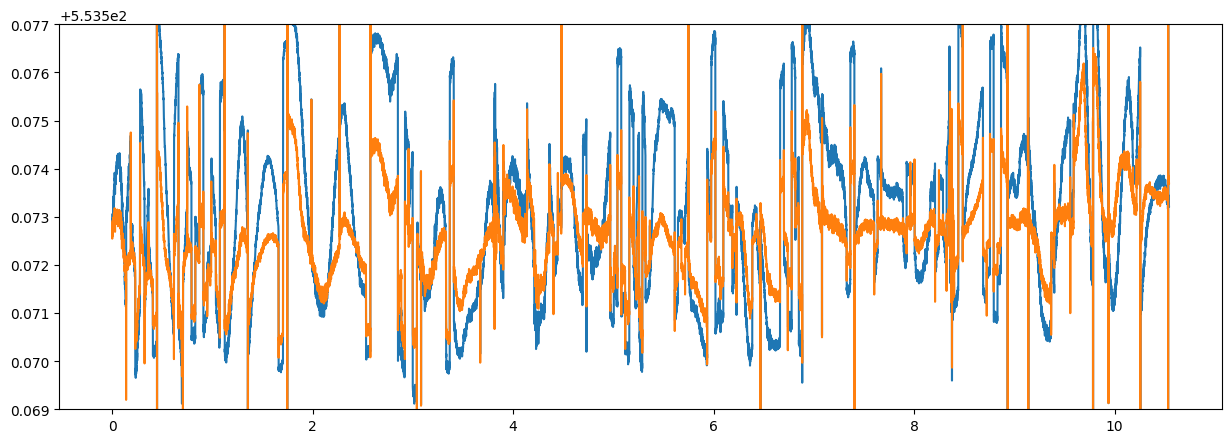

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.plot(bs.time_sec/86400, bs.fj_bs)

# plt.plot(bs.time_sec/86400, gaussian_filter1d(bs.fj_bs, 2))

plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [11]:
bs['fj_fs'] = np.where((bs.fj_fs > flim2), np.nan, bs.fj_fs)
bs['fj_fs'] = np.where((bs.fj_fs < flim1), np.nan, bs.fj_fs)

bs['fj_bs'] = np.where((bs.fj_bs > flim2), np.nan, bs.fj_bs)
bs['fj_bs'] = np.where((bs.fj_bs < flim1), np.nan, bs.fj_bs)

In [12]:
def __time_spans_to_nan(bs, time_spans):

    for t1, t2 in time_spans:
        bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
        bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)


In [20]:
time_spans = [("2024-06-20T12:00", "2024-06-21T12:00"),
              ("2024-06-24T12:00", "2024-06-26T06:00")
             ]

__time_spans_to_nan(bs, time_spans)

In [21]:
from functions.load_mlti import __load_mlti

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

In [22]:
from functions.get_mlti_intervals import __get_mlti_intervals

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

In [23]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=300)

### Apply special filter sections

In [24]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [25]:
from functions.smoothing import __smooth

n_minutes = 30

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [26]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Dejump

In [27]:
from functions.get_phase_jumps_sta_lta import get_phase_jumps_sta_lta

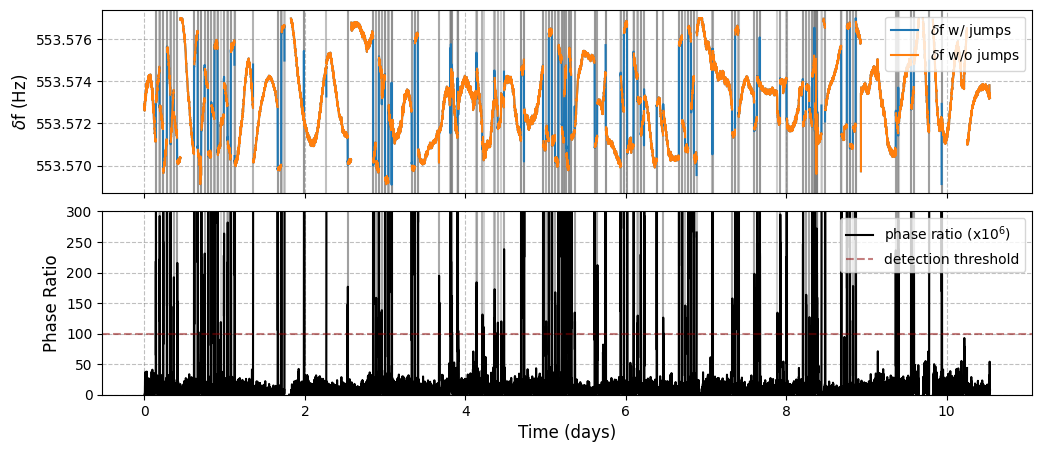

In [29]:
ratio, detect, _ = get_phase_jumps_sta_lta(np.array(bs.fj_fs), np.array(bs.time_sec), 5, 3, amp_threshold=0.0001)

In [30]:
mask1 = np.where(detect == 1, bs.time1, np.nan)
mask2 = np.where(detect == 1, bs.time2, np.nan)

mask_df = DataFrame()
mask_df['mask1'] = mask1
mask_df['mask2'] = mask2

mask_df = mask_df.dropna()

mask1 = np.array(mask_df.mask1)
mask2 = np.array(mask_df.mask2)

In [33]:
from functions.correct_phase_jumps import __correct_phase_jumps

In [39]:
# get index for mlti launches
mlti_sec = [int((UTCDateTime(_t) - config['tbeg'])/config['delta']) for _t in mlti.time_utc]

# add mlti launches to detected jumps for correction
for _i in mlti_sec:
    detect[_i] = 1
    # detect[_i+10] = 1

In [40]:
bs['fj_fs_dejump'] = __correct_phase_jumps(bs.fj_fs_inter, detect)
bs['fj_bs_dejump'] = __correct_phase_jumps(bs.fj_bs_inter, detect)

### Checkup Plot

/tmp/ipykernel_3940950/2163252932.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


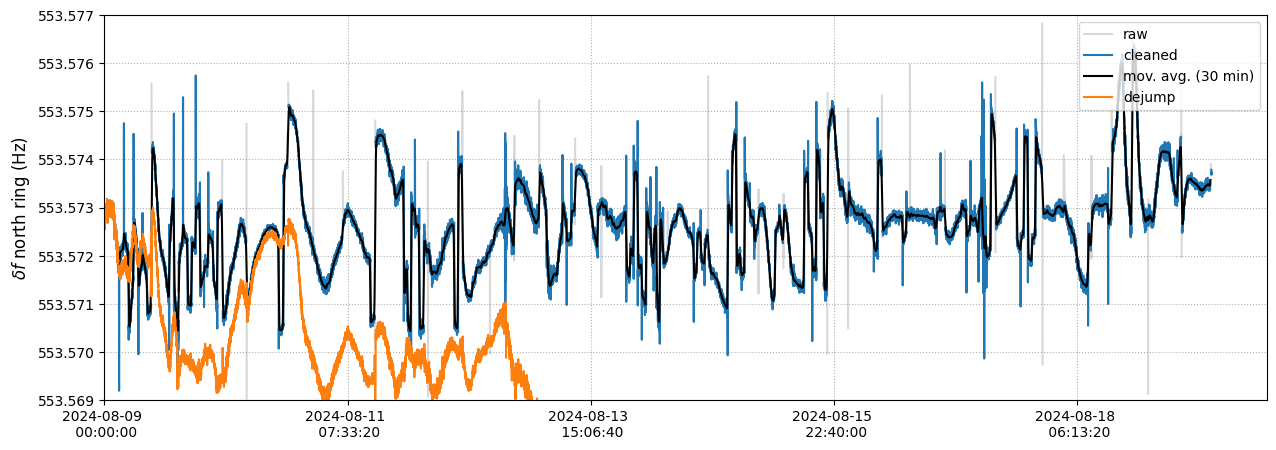

In [41]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_bs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_bs_nan, color="tab:blue", label="cleaned")
    ax.plot(bs.time_sec*time_scaling, bs.fj_bs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.plot(bs.time_sec*time_scaling, bs.fj_bs_dejump, color="tab:orange", label="dejump")

    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    # add maintenance intervals
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    # add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_cleaned.png", format="png", dpi=150, bbox_inches='tight')


### Load WROMY Data

In [42]:
ws = Stream()
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

ws = ws.merge();

ws

3 Trace(s) in Stream:
BW.WROMY.01.LKI | 2024-08-09T11:00:00.000000Z - 2024-08-19T23:59:59.000000Z | 1.0 Hz, 910800 samples
BW.WROMY.05.LKI | 2024-08-09T11:00:00.000000Z - 2024-08-19T23:59:59.000000Z | 1.0 Hz, 910800 samples
BW.WROMY.09.LKI | 2024-08-09T11:00:00.000000Z - 2024-08-19T23:59:59.000000Z | 1.0 Hz, 910800 samples

### Load PROMY Data

In [74]:
ps = Stream()
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

ps3 = ps.merge();

ps

5 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-08-09T11:00:00.000000Z - 2024-08-19T23:59:59.000000Z | 1.0 Hz, 910800 samples
BW.PROMY.03.LKI | 2024-08-09T11:00:00.000000Z - 2024-08-19T23:59:59.000000Z | 1.0 Hz, 910800 samples
BW.PROMY.05.LKI | 2024-08-09T11:00:00.000000Z - 2024-08-19T23:59:59.000000Z | 1.0 Hz, 910800 samples
BW.PROMY.07.LKI | 2024-08-09T11:00:00.000000Z - 2024-08-19T23:59:59.000000Z | 1.0 Hz, 910800 samples
BW.PROMY.09.LKI | 2024-08-09T11:00:00.000000Z - 2024-08-19T23:59:59.000000Z | 1.0 Hz, 910800 samples

### Load Rain Data

In [44]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [45]:
furt = __load_furt_stream(config['tbeg']-3*86400, config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

 -> loading of FURT.WSX.D.060824.0000 failed!
local variable 'df0' referenced before assignment
 -> loading of FURT.WSX.D.070824.0000 failed!
local variable 'df0' referenced before assignment
 -> loading of FURT.WSX.D.080824.0000 failed!
local variable 'df0' referenced before assignment
 -> loading of FURT.WSX.D.090824.0000 failed!
local variable 'df0' referenced before assignment
 -> loading of FURT.WSX.D.100824.0000 failed!
local variable 'df0' referenced before assignment
 -> loading of FURT.WSX.D.110824.0000 failed!
local variable 'df0' referenced before assignment
 -> loading of FURT.WSX.D.120824.0000 failed!
local variable 'df0' referenced before assignment
  -> FURT.WSX.D.060824.0000, failed!
  -> FURT.WSX.D.070824.0000, failed!
  -> FURT.WSX.D.080824.0000, failed!
  -> FURT.WSX.D.090824.0000, failed!
  -> FURT.WSX.D.100824.0000, failed!
  -> FURT.WSX.D.110824.0000, failed!
  -> FURT.WSX.D.120824.0000, failed!


/home/brotzer/andbro_python/andbro__load_FURT_stream.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="ignore")


In [47]:
rain = furt.select(channel="LAR")

rain = rain.trim(config['tbeg'], config['tend'])

for tr in rain:
    tr.data = np.nan_to_num(tr.data, 0)

# smoothed precipitation
rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)

# cumulative rain
rain_cumsum = np.nancumsum(rain[0].data)

### Load Tilt Data

In [48]:
from functions.conversion_to_tilt import __conversion_to_tilt

In [49]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

tromy0 =  __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

  -> converted data of ROMYT


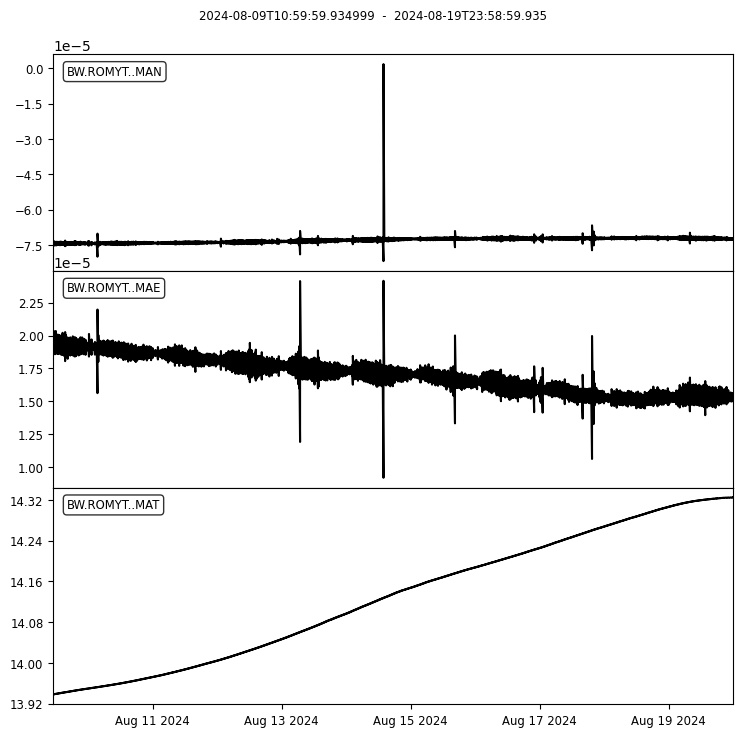

In [50]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

tromy0 = tromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

tromy = tromy0.copy();
del tromy0

tromy = tromy.merge();

tromy.plot(equal_scale=False);

In [ ]:
NN = int(20*tromy.select(channel="*N")[0].stats.sampling_rate)

tromyN_smooth = __smooth(__reduce(tromy.select(channel="*N")[0].data, 100), NN)
tromyE_smooth = __smooth(__reduce(tromy.select(channel="*E")[0].data, 100), NN)

In [51]:
# # path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
# path_to_tilt = archive_path+"romy_archive/"

# bromy0 =  __read_sds(path_to_tilt, "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
# bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAE", config['tbeg']-600, config['tend']+600)
# bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)

# bromy0.plot(equal_scale=False)

In [53]:
# print(bromy0)

# bromy0 = bromy0.decimate(10, no_filter=False);
# bromy0 = bromy0.decimate(10, no_filter=False);
# bromy0 = bromy0.decimate(2, no_filter=False);

# print(bromy0)

3 Trace(s) in Stream:
BW.DROMY..LAN | 2024-08-09T10:50:00.000000Z - 2024-08-20T00:10:00.000000Z | 200.0 Hz, 182400001 samples
BW.DROMY..LAE | 2024-08-09T10:50:00.000000Z - 2024-08-20T00:10:00.000000Z | 200.0 Hz, 182400001 samples
BW.DROMY..LAT | 2024-08-09T10:50:00.000000Z - 2024-08-20T00:10:00.000000Z | 200.0 Hz, 182400001 samples
3 Trace(s) in Stream:
BW.DROMY..LAN | 2024-08-09T10:50:00.000000Z - 2024-08-20T00:10:00.000000Z | 1.0 Hz, 912001 samples
BW.DROMY..LAE | 2024-08-09T10:50:00.000000Z - 2024-08-20T00:10:00.000000Z | 1.0 Hz, 912001 samples
BW.DROMY..LAT | 2024-08-09T10:50:00.000000Z - 2024-08-20T00:10:00.000000Z | 1.0 Hz, 912001 samples


  -> converted data of DROMY


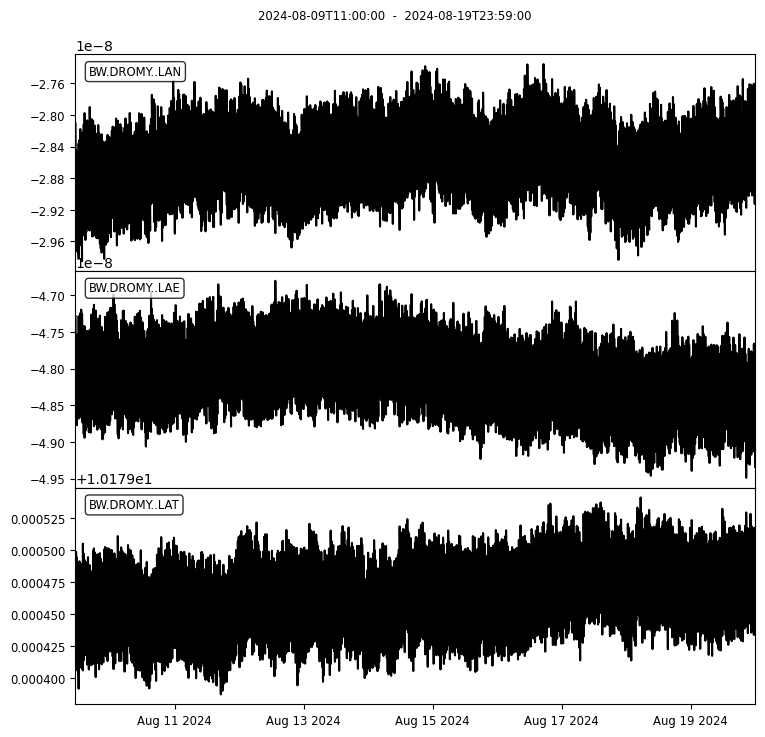

In [54]:
# ## tiltmeter configurations
# confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

# bromy0 = __conversion_to_tilt(bromy0, confTilt['BROMY'])

# bromy0 = bromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

# # bromy0 = bromy0.filter("lowpass", freq=0.5, corners=4, zerophase=True)
# # bromy0 = bromy0.resample(1.0)

# bromy = bromy0.copy();

# bromy = bromy.merge(fill_value="interpolate");

# bromy.plot(equal_scale=False);

# del bromy0;

In [ ]:
# bromyN_smooth = __reduce(bromy.select(channel="*N")[0].data, 100)
# bromyE_smooth = __reduce(bromy.select(channel="*E")[0].data, 100)

### Load Water Level Data

In [55]:
from functions.load_water_level import __load_water_level

In [56]:
try:
    pegel =  __load_water_level(config['tbeg'], config['tend'], path_to_data=lamont_path+"Pegel/")

    ## remove error measurements with nan
    pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)

    pegel
except Exception as e:
    print(e)
    print(" -> pegel not loaded")


,index,day,time,pegel,temperatur,times_utc,times_utc_sec
1320,1320,09.08.2024,11:00:00,3.754200,8.9745,2024-08-09T11:00:00.000000Z,0.0
1321,1321,09.08.2024,11:00:30,3.754725,8.9725,2024-08-09T11:00:30.000000Z,30.0
1322,1322,09.08.2024,11:01:00,3.756075,8.9745,2024-08-09T11:01:00.000000Z,60.0
1323,1323,09.08.2024,11:01:30,3.757275,8.9750,2024-08-09T11:01:30.000000Z,90.0
1324,1324,09.08.2024,11:02:00,3.757200,8.9750,2024-08-09T11:02:00.000000Z,120.0
...,...,...,...,...,...,...,...
31675,2875,19.08.2024,23:57:30,3.659100,8.9600,2024-08-19T23:57:30.000000Z,910650.0
31676,2876,19.08.2024,23:58:00,3.661875,8.9615,2024-08-19T23:58:00.000000Z,910680.0
31677,2877,19.08.2024,23:58:30,3.661050,8.9610,2024-08-19T23:58:30.000000Z,910710.0
31678,2878,19.08.2024,23:59:00,3.661125,8.9610,2024-08-19T23:59:00.000000Z,910740.0


### Load Beam Wander Data

In [57]:
from functions.load_beam_wander_data import __load_beam_wander_data

In [71]:
ids = "03"

bw = __load_beam_wander_data(config['tbeg'].date, config['tend'].date, data_path+f"ids/data{ids}/")

2024-08-09
2024-08-10
2024-08-11
2024-08-12
2024-08-13
2024-08-14
2024-08-15
2024-08-16
2024-08-17
2024-08-18
2024-08-19
2024-08-20
error for 20240820.pkl


In [72]:
bw = bw[(bw.time > config['tbeg']) & (bw.time < config['tend'])]

bw['time_utc'] = np.array([UTCDateTime(_t) for _t in bw.time])

# conversion from pixel to mm
# config['conversion'] = {"XX":1.67e-3,
#                         "01":5.3e-3,
#                         "03":5.3e-3,
#                         "07":5.3e-3,
#                        }

bw['x_mm'] = bw.x*5.3e-3
bw['y_mm'] = bw.y*5.3e-3

bw['x_mm'] = __reduce(bw.x_mm, 100)
bw['y_mm'] = __reduce(bw.y_mm, 100)

bw = bw[bw.amp > 20]
bw = bw[bw.amp < 255]


In [73]:
gc.collect()

37892

### Load Infrasound FFBI

In [61]:
ffbi = __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDF", config['tbeg'], config['tend'])
ffbi += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])

In [62]:
ffbi_bdf_smooth1 = __smooth(ffbi.select(channel="*F")[0].data, int(60*ffbi.select(channel="*F")[0].stats.sampling_rate))
ffbi_bdf_smooth2 = __smooth(ffbi.select(channel="*F")[0].data, int(3600*ffbi.select(channel="*F")[0].stats.sampling_rate))

## Plotting

In [66]:
from functions.find_max_min import __find_max_min

In [65]:
def find_max_min(lst, pp=99):
    maxs, mins = [], []
    for l in lst:
        maxs.append(np.nanpercentile(l, pp))
        mins.append(np.nanpercentile(l, 100-pp))
    return min(mins), max(maxs)

/tmp/ipykernel_3940950/3517984918.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[Nrow-1].set_xticklabels(tcklbls)


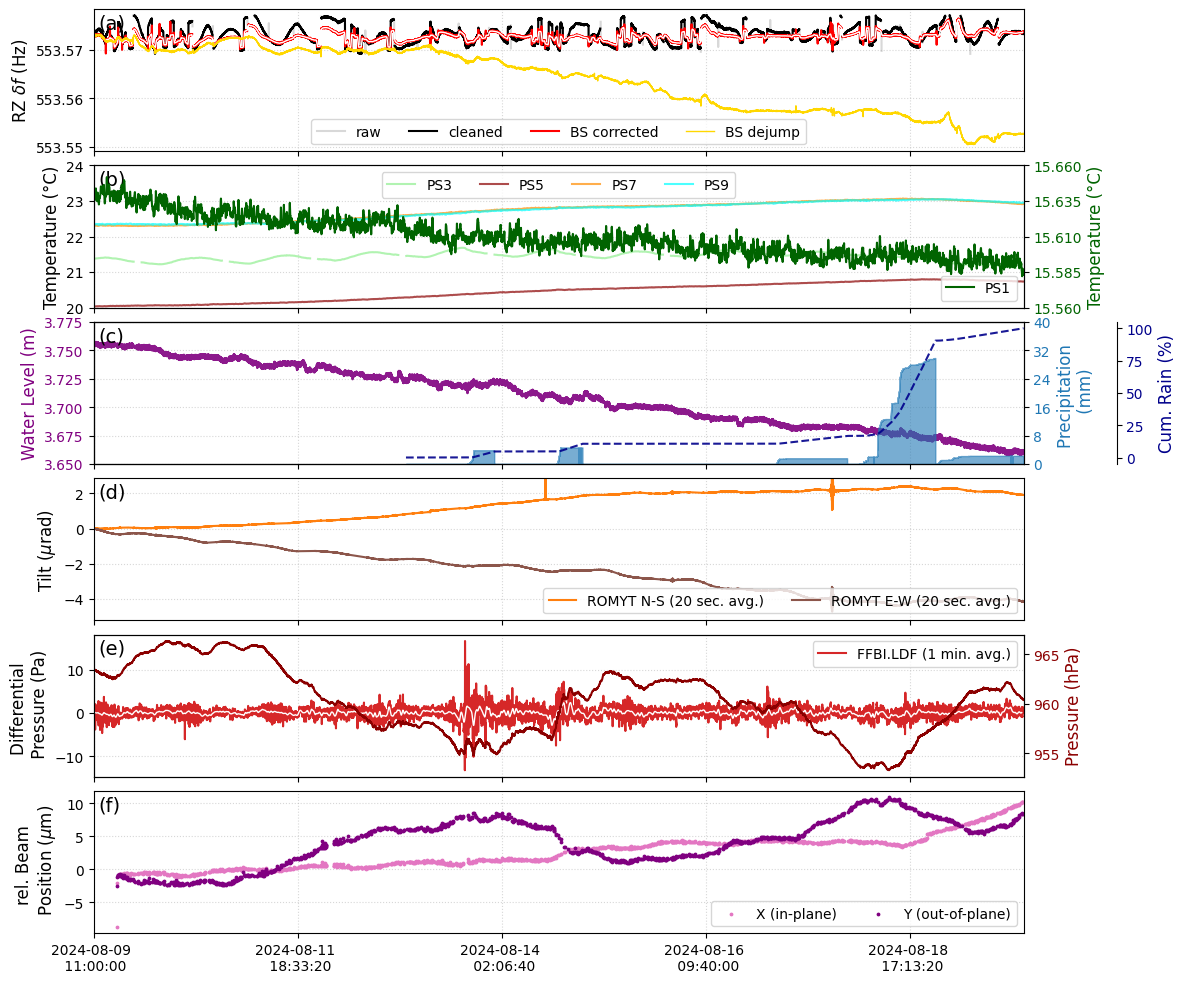

In [94]:
def __makeplot():

    Nrow, Ncol = 6, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    ref_date = UTCDateTime(bs.time1.iloc[0])
    ref_date = UTCDateTime(config['tbeg'])

    # _____________________________________________________________________________________
    #
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="black", label="cleaned")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_bs_nan, color="red", label=f"BS corrected")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_bs_smooth, color="white", lw=1)
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_bs_dejump, color="gold", lw=1, label=f"BS dejump")

    # ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel(f"R{config['ring']} $\delta f$ (Hz)", fontsize=font)

    # _____________________________________________________________________________________
    #
    for tr in ws.select(channel="*T"):
        num = int(tr.stats.location[-1])
        if num != 1:
            ax[1].plot(tr.times(reftime=ref_date),
                       __smooth(tr.data, 600), color=config['colors'][num], label=f"WS{num}", alpha=0.7)

    for tr in ps.select(channel="*KI"):
        num = int(tr.stats.location[-1])
        if num != 1:
            ax[1].plot(tr.times(reftime=ref_date),
                       __smooth(tr.data, 600), color=config['colors'][num], label=f"PS{num}", alpha=0.7)

    y_min, y_max = find_max_min([_ps.data for _ps in ps.select(channel="*KI") if "1" not in _ps.stats.location], 98)
    # ax[1].set_ylim(10, 22)
    ax[1].set_ylim(y_min, y_max)

    ax[1].set_ylabel("Temperature (°C)", fontsize=font)

    ax11 = ax[1].twinx()
    ax11.plot(ps.select(location="01", channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
              __smooth(ps.select(location="01", channel="*KI")[0].data, 600), color=config['colors'][1], label="PS1")

    ax11.set_ylabel("Temperature (°C)", fontsize=font, color=config['colors'][1])
    [t.set_color(config['colors'][1]) for t in ax11.yaxis.get_ticklabels()]
    ax[1].set_yticks(np.linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))



    # _____________________________________________________________________________________
    #
    try:
        ax[2].plot(pegel.times_utc - ref_date, pegel.pegel, color="purple", alpha=0.9, zorder=3)
    except:
        pass
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font, color="purple")
    # ax[2].set_zorder(3)
    [t.set_color("purple") for t in ax[2].yaxis.get_ticklabels()]

    ax22 = ax[2].twinx()
    ax22.fill_between(rain[0].times(reftime=ref_date),
                      __interpolate_nan(rain[0].data), color="tab:blue", alpha=0.6, label=f"rain", zorder=0)

    ax22.set_ylim(bottom=0)
    ax22.set_ylabel(f"Precipitation \n (mm)", fontsize=font, color="tab:blue")
    [t.set_color('tab:blue') for t in ax22.yaxis.get_ticklabels()]

    ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(np.linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))
    # ax22.set_zorder(2)


    ax24 = ax[2].twinx()
    ax24.plot(rain[0].times(reftime=ref_date), rain_cumsum/max(rain_cumsum)*100, alpha=0.9, zorder=1, ls="--", color="darkblue")

    # ax24.axis('off')
    # ax24.set_zorder(1)
    ax24.spines.right.set_position(("axes", 1.1))
    ax24.set_ylabel(f"Cum. Rain (%)", fontsize=font, color="darkblue")
    [t.set_color('darkblue') for t in ax24.yaxis.get_ticklabels()]


    # _____________________________________________________________________________________
    #
    ax[3].plot(tromy.select(channel="*N")[0].times(reftime=ref_date)[:-20],
               tromyN_smooth[:-20]*1e6,
               label=f"{tromy[0].stats.station} N-S (20 sec. avg.)", color="tab:orange")
    ax[3].plot(tromy.select(channel="*E")[0].times(reftime=ref_date)[:-20],
               tromyE_smooth[:-20]*1e6,
               label=f"{tromy[0].stats.station} E-W (20 sec. avg.)", color="tab:brown")
    # ax[3].plot(bromy.select(channel="*N")[0].times(reftime=UTCDateTime(ref_date))[:-20],
    #            bromyN_smooth[:-20]*1e6,
    #            label=f"{bromy[0].stats.station} N-S (20 sec. avg.)", color="tab:red")
    # ax[3].plot(bromy.select(channel="*E")[0].times(reftime=UTCDateTime(ref_date))[:-20],
    #            bromyE_smooth[:-20]*1e6,
    #            label=f"{bromy[0].stats.station} E-W (20 sec. avg.)", color="tab:blue")


    ax[3].set_ylabel("Tilt ($\mu$rad)", fontsize=font)

    y_min, y_max = find_max_min([tromyN_smooth*1e6, tromyE_smooth*1e6], pp=99)
    ax[3].set_ylim(y_min*1.2, y_max*1.2)

    # _____________________________________________________________________________________
    #
    ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=ref_date),
               ffbi_bdf_smooth1,
               label=f"{ffbi.select(channel='*F')[0].stats.station}.{ffbi.select(channel='*F')[0].stats.channel} (1 min. avg.)",
               color="tab:red"
              )
    ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=ref_date),
               ffbi_bdf_smooth2,
               color="white", ls="-", lw=1,
              )

    ax[4].set_ylabel("Differential \n Pressure (Pa)", fontsize=font)

    ax41 = ax[4].twinx()
    ax41.plot(ffbi.select(channel="*O")[0].times(reftime=ref_date),
              ffbi.select(channel="*O")[0].data,
              color="darkred"
              )
    ax41.set_ylabel("Pressure (hPa)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax41.yaxis.get_ticklabels()]

    # ------------------------------------------------
    # add wind direction
    # ax42 = ax[4].twinx()
    # ax42.scatter(furt.select(channel="*D")[0].times(reftime=config['tbeg']),
    #              __smooth(furt.select(channel="*D")[0].data, 3600), color="peru", s=0.5, alpha=0.5,
    #             )
    # ax42.spines.right.set_position(("axes", 1.1))
    # ax42.set_ylabel("Wind Direction (°)", fontsize=font, color="peru")
    # [t.set_color('peru') for t in ax42.yaxis.get_ticklabels()]
    # ax42.set_ylim(0, 360)
    # ax42.set_zorder(1)

    # _____________________________________________________________________________________
    #
    ax[5].scatter(bw.time_utc - ref_date,
                  bw.x_mm*1e3,
                  label=f"X (in-plane)",
                  color="tab:pink",
                  zorder=2,
                  s=3,
              )
    ax[5].scatter(bw.time_utc - ref_date,
                  bw.y_mm*1e3,
                  label=f"Y (out-of-plane)",
                  color="purple",
                  zorder=2,
                  s=3,
              )

    ax[5].set_ylabel("rel. Beam \n Position ($\mu$m)", fontsize=font)
    # ax[5].set_ylim(-500, 500)


    # _____________________________________________________________________________________
    #
    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0, alpha=0.5)
        ax[_n].set_xlim(left=0, right=np.array(bs.time_sec)[-1]*time_scaling)


    ax[0].legend(loc=8, ncol=4)
    ax[1].legend(loc=9, ncol=4)
    ax11.legend(loc=4, ncol=1)
    ax[3].legend(loc=4, ncol=2)
    ax[4].legend(loc=1, ncol=1)
    ax[5].legend(loc=4, ncol=2)

    # ax[Nrow-1].set_xlabel("Time (days)", fontsize=font)

    # add maintenance
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax[0].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_shortterm_environmentals_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')

del fig

/tmp/ipykernel_3940950/3809014885.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(tcklbls)


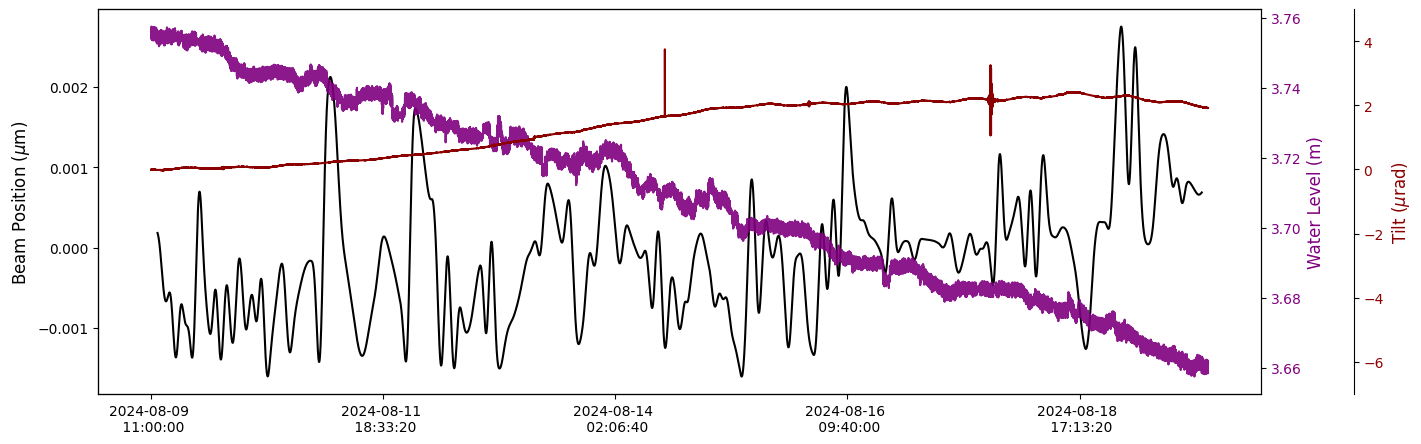

In [93]:
def __makeplot():

    ref_date = config['tbeg']

    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

    font = 12

    # ax1.scatter(bw.time_utc - bw.time_utc.iloc[0],
    #             -1*__reduce(bw.y_mm*1e3, 10),
    #             label=f"-1x Y (out-of-plane)",
    #             color="k",
    #             zorder=2,
    #             s=3,
    #             )

    ax1.plot(bs.time1 - ref_date,
             __smooth(__reduce(bs.fj_bs_inter, 10), 180),
             color="k"
            )

    # ax1.set_ylim(-70, 30)
    ax1.set_ylabel("Beam Position ($\mu$m)", fontsize=font)

    ax41 = ax1.twinx()
    # ax41.plot(ffbi.select(channel="*O")[0].times(reftime=ref_date),
    #           ffbi.select(channel="*O")[0].data,
    #           color="blue"
    #           )
    # ax41.set_ylabel("Pressure (hPa)", fontsize=font, color="blue")

    #
    try:
        ax41.plot(pegel.times_utc - ref_date, pegel.pegel, color="purple", alpha=0.9, zorder=3)
    except:
        pass
    ax41.set_ylabel(f"Water Level (m)", fontsize=font, color="purple")
    [t.set_color('purple') for t in ax41.yaxis.get_ticklabels()]

    ax2 = ax1.twinx()

    ax2.plot(tromy.select(component="N")[0].times(reftime=config['tbeg']),
             tromyN_smooth*1e6, color="darkred",
               )
    # ax2.plot(tromy.select(component="E")[0].times(reftime=ref_date),
    #          tromyE_smooth*1e6, color="red"
    #            )
    # ax2.plot(bromy.select(component="N")[0].times(reftime=config['tbeg']),
    #          bromyN_smooth*1e6, color="darkorange", ls="--",
    #            )
    # ax2.plot(bromy.select(component="E")[0].times(reftime=ref_date),
    #          bromyE_smooth*1e6, color="green"
    #            )
    ax2.set_ylim(-7, 5)
    ax2.spines.right.set_position(("axes", 1.08))
    ax2.set_ylabel("Tilt ($\mu$rad)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax2.yaxis.get_ticklabels()]

    ## add dates to x-axis
    tcks = ax1.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax1.set_xticklabels(tcklbls)

    return fig

fig = __makeplot()


## prepare Hilbert transform of pressure

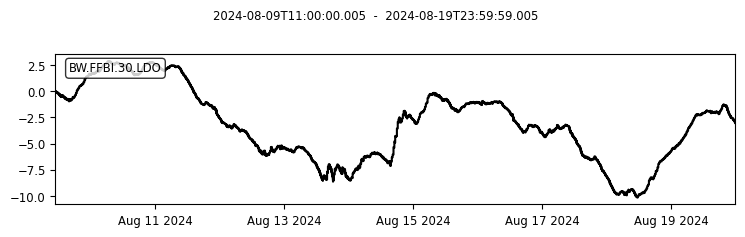

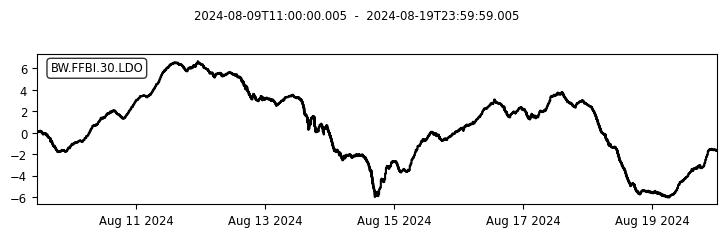

In [88]:
pp = ffbi.select(channel="*DO").copy()

hp = pp.copy()


for tr in hp:
    NN = int(1e6)
    tr.data = np.pad(tr.data, (NN, NN), mode="edge")

    tr.data = np.imag(hilbert(tr.data))

    tr.data = tr.data[NN:-NN]

# hp = hp.detrend("simple")
# pp = pp.detrend("simple")

for tr in pp:
    tr.data = __reduce(tr.data, 100)

for tr in hp:
    tr.data = __reduce(tr.data, 100)

pp.plot();
hp.plot();

## Define Dataframe

In [89]:

df = DataFrame()

reftime = bs.time1.iloc[0]

df['time'] = bs.time_sec

df['fj_fs'] = __reduce(bs.fj_fs_inter, 10)

df['fj_bs'] = __reduce(bs.fj_bs_inter, 10)

df['fj_bs_dj'] = __reduce(bs.fj_bs_dejump, 10)

# ps3_data = __reduce(__interpolate_nan(ps.select(location="03")[0].data), 100)
# df['ps3'] = np.interp(df.time, ps.select(location="03")[0].times(reftime=reftime), ps3_data)

ps1_data = __reduce(__interpolate_nan(__smooth(ps.select(location="01")[0].data, 1800)), 100)
df['ps1'] = np.interp(df.time, ps.select(location="01")[0].times(reftime=reftime), ps1_data)

ps7_data = __reduce(__interpolate_nan(__smooth(ps.select(location="07")[0].data, 1800)), 100)
df['ps7'] = np.interp(df.time, ps.select(location="07")[0].times(reftime=reftime), ps7_data)

ps9_data = __reduce(__interpolate_nan(__smooth(ps.select(location="09")[0].data, 1800)), 100)
df['ps9'] = np.interp(df.time, ps.select(location="09")[0].times(reftime=reftime), ps9_data)

# bdo_data = __reduce(ffbi.select(channel="*DO")[0].data, 100)
bdo_data = pp.select(channel="*DO")[0].data
df['bdo'] = np.interp(df.time, ffbi.select(channel="*DO")[0].times(reftime=reftime), bdo_data)

hp_data = hp.select(channel="*DO").detrend("simple")[0].data
df['hp'] = np.interp(df.time, ffbi.select(channel="*DO")[0].times(reftime=reftime), hp_data)

# bdf_data = __reduce(__interpolate_nan(__smooth(ffbi.select(channel="*DF")[0].data, 600)), 100)
bdf_data = ffbi_bdf_smooth2
df['bdf'] = np.interp(df.time, ffbi.select(channel="*DF")[0].times(reftime=reftime), bdf_data)

man_data = __reduce(__interpolate_nan(__smooth(tromy.select(channel="MAN")[0].data, 5*60)), 100)
df['man'] = np.interp(df.time, tromy.select(channel="MAN")[0].times(reftime=reftime), man_data)

mae_data = __reduce(__interpolate_nan(__smooth(tromy.select(channel="MAE")[0].data, 5*60)),100)
df['mae'] = np.interp(df.time, tromy.select(channel="MAE")[0].times(reftime=reftime), mae_data)

peg_data = __reduce(__interpolate_nan(__smooth(pegel.pegel, 20)), 100)
df['peg'] = np.interp(df.time, pegel.times_utc - bs.time1.iloc[0], peg_data)

bwx = np.array(bw.x_mm)
# bwx = np.where((abs(np.diff(bwx, prepend=0)) > 0.001), np.nan, bwx)
# bwx = np.where((abs(bwx) > 0.1), np.nan, bwx)

df['bwx'] = np.interp(df.time, np.array(bw.time_utc - bs.time1.iloc[0], dtype=float), __interpolate_nan(__smooth(__interpolate_nan(bwx), 10)))

bwy = np.array(bw.y_mm)
# bwy = np.where((abs(np.diff(bwy, prepend=0)) > 0.001), np.nan, bwy)
# bwy = np.where((abs(bwy) > 0.1), np.nan, bwy)

df['bwy'] = np.interp(df.time, np.array(bw.time_utc - bs.time1.iloc[0], dtype=float), __interpolate_nan(__smooth(__interpolate_nan(bwy), 10)))


In [90]:
df.to_pickle(config['path_to_out_data']+f"multi_regression_R{config['ring']}_df3.pkl")